In [1]:
import time
import numpy as np
import pandas as pd

import scipy.stats as stats

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split, GridSearchCV, cross_validate
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

In [2]:
# Load data
df = pd.read_csv('data/creditcard.csv')

In [3]:
# Scaling
scaler = RobustScaler()

df['scaled_amount'] = scaler.fit_transform(df['Amount'].values.reshape(-1, 1))
df['scaled_time'] = scaler.fit_transform(df['Time'].values.reshape(-1, 1))

df.drop(['Amount', 'Time'], axis=1, inplace=True)

In [4]:
# Calculate Point Biserial Correlation
features = df.columns.tolist()
features.remove('Class')

corr = {}
for i in features: 
    corr[i] = stats.pointbiserialr(df[i], df['Class'])[0]

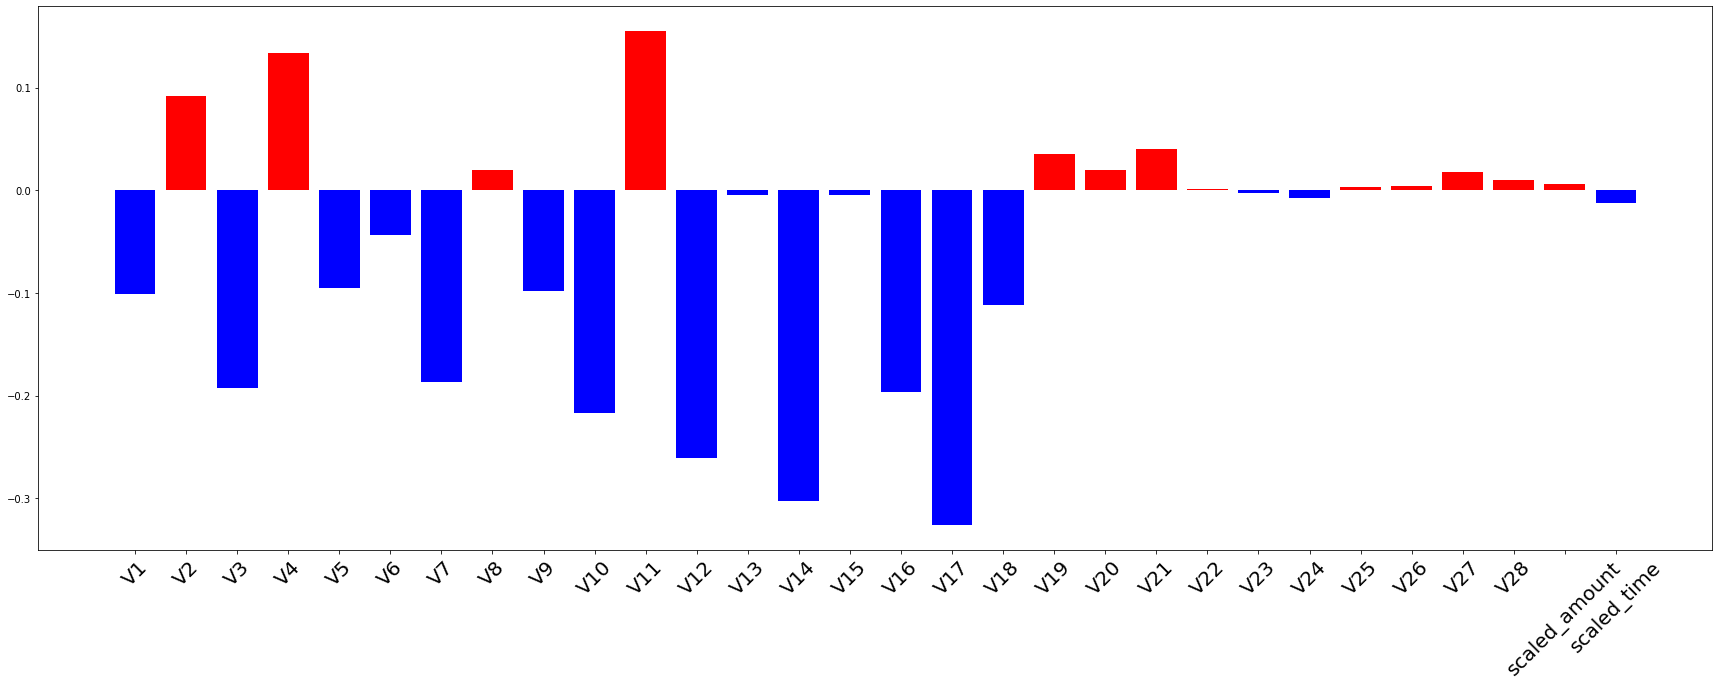

In [5]:
# Check with Bar plot
x = np.arange(len(corr))
colors = clrs = ['blue' if x < 0 else 'red' for x in corr.values()]
plt.figure(figsize=(30, 10))
plt.bar(x, corr.values(), color=colors)
plt.xticks(x, corr.keys(), rotation=45, fontsize=20)
plt.show()

In [6]:
# w/ & w/o feature selection
w_df = df[['V1', 'V3', 'V5', 'V7', 'V9', 'V10', 'V12', 'V14', 'V16', 'V17', 'V18', 'V2', 'V4', 'V11', 'Class']]
wo_df = df

In [7]:
def train_and_test(df):
    # Split train and test
    train, test = train_test_split(df, test_size=0.2, shuffle=True, random_state=42, stratify=df['Class'])

    # Under Sampling train dataset
    fraud = train[train['Class']==1].reset_index(drop=True)
    normal = train[train['Class']==0]

    num_of_normal = len(fraud) * 4    # 2:8 비율
    normal = normal.sample(n=num_of_normal, random_state=42, ignore_index=True)
    train = pd.concat([fraud, normal], ignore_index=True)

    # Train Classifier
    X_train = train.drop('Class', axis=1)
    y_train = train['Class']
    X_test = test.drop('Class', axis=1)
    y_test = test['Class']

    model = LogisticRegression(max_iter=10000)
    params = {'penalty':['l2'], 'C':[0.001, 0.01, 0.1, 1, 10, 100, 1000]}
    grid = GridSearchCV(model, params, scoring=['accuracy', 'roc_auc'], refit='roc_auc', return_train_score=True, cv=5)
    grid.fit(X_train, y_train)

    print('< Logistic Regression Results >')
    print(f'Total fit time: {grid.cv_results_["mean_fit_time"].sum()}')
    print(f'The best params: {grid.best_params_}')
    print(f'Test accuracy: {round(grid.score(X_test, y_test) * 100, 2)}%')
    print('\n')

    model = KNeighborsClassifier()
    params = {"n_neighbors": list(range(2,5,1)), 'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute']}
    grid = GridSearchCV(model, params, scoring=['accuracy', 'roc_auc'], refit='roc_auc', return_train_score=True, cv=5)
    grid.fit(X_train, y_train)

    print('< K-Neighbors Results >')
    print(f'Total fit time: {grid.cv_results_["mean_fit_time"].sum()}')
    print(f'The best params: {grid.best_params_}')
    print(f'Test accuracy: {round(grid.score(X_test, y_test) * 100, 2)}%')
    print('\n')

    model = SVC()
    params = {'C': [0.5, 0.7, 0.9, 1], 'kernel': ['rbf', 'poly', 'sigmoid', 'linear']}
    grid = GridSearchCV(model, params, scoring=['accuracy', 'roc_auc'], refit='roc_auc', return_train_score=True, cv=5)
    grid.fit(X_train, y_train)

    print('< SVC Results >')
    print(f'Total fit time: {grid.cv_results_["mean_fit_time"].sum()}')
    print(f'The best params: {grid.best_params_}')
    print(f'Test accuracy: {round(grid.score(X_test, y_test) * 100, 2)}%')
    print('\n')

    model = DecisionTreeClassifier()
    params = {
        "criterion": ["gini", "entropy"], 
        "max_depth": list(range(2,10,1)), 
        "min_samples_leaf": list(range(2,10,1))
    }
    grid = GridSearchCV(model, params, scoring=['accuracy', 'roc_auc'], refit='roc_auc', return_train_score=True, cv=5)
    grid.fit(X_train, y_train)

    print('< Decision Tree Results >')
    print(f'Total fit time: {grid.cv_results_["mean_fit_time"].sum()}')
    print(f'The best params: {grid.best_params_}')
    print(f'Test accuracy: {round(grid.score(X_test, y_test) * 100, 2)}%')
    print('\n')

In [8]:
train_and_test(w_df)

< Logistic Regression Results >
Total fit time: 0.040583944320678716
The best params: {'C': 0.01, 'penalty': 'l2'}
Test accuracy: 97.71%


< K-Neighbors Results >
Total fit time: 0.018461465835571293
The best params: {'algorithm': 'auto', 'n_neighbors': 4}
Test accuracy: 95.91%


< SVC Results >
Total fit time: 0.18451695442199706
The best params: {'C': 1, 'kernel': 'poly'}
Test accuracy: 97.89%


< Decision Tree Results >
Total fit time: 1.0600231647491456
The best params: {'criterion': 'entropy', 'max_depth': 4, 'min_samples_leaf': 8}
Test accuracy: 95.37%




In [9]:
train_and_test(wo_df)

< Logistic Regression Results >
Total fit time: 0.1796706676483154
The best params: {'C': 0.01, 'penalty': 'l2'}
Test accuracy: 97.69%


< K-Neighbors Results >
Total fit time: 0.02314105033874512
The best params: {'algorithm': 'auto', 'n_neighbors': 4}
Test accuracy: 95.92%


< SVC Results >
Total fit time: 0.27721714973449707
The best params: {'C': 1, 'kernel': 'rbf'}
Test accuracy: 97.6%


< Decision Tree Results >
Total fit time: 2.078251504898071
The best params: {'criterion': 'entropy', 'max_depth': 5, 'min_samples_leaf': 9}
Test accuracy: 94.86%


